# Naive Bayes

## Packages

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
import os

## Data Preprocessing

In [18]:
path = os.getcwd()
print(path)

/home/pavan/Desktop/Projects/ML-assignment/Naive-Bayes


In [19]:
file1 = open('dataset_NB.txt', 'r')
Lines = file1.readlines()

<b>Insert data from txt file to a dictionary.
Sepearte out the Labels.</b>

In [21]:
dict_data = {'text':[], 'label':[]}
for i in Lines:
  label = i[-2]
  string = i[:-2]
  dict_data['text'].append(string)
  dict_data['label'].append(label)
dict_data['label'][-1] = '0'

In [23]:
dict_data['text'][:10]

['So there is no way for me to plug it in here in the US unless I go by a converter.  ',
 'Good case, Excellent value. ',
 'Great for the jawbone.  ',
 'Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!! ',
 'The mic is great.   ',
 'I have to jiggle the plug to get it to line up right to get decent volume.  ',
 'If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one. ',
 'If you are Razr owner...you must have this! ',
 'Needless to say, I wasted my money. ',
 'What a waste of money and time!.    ']

In [24]:
dict_data['label'][:10]

['0', '1', '1', '0', '1', '0', '0', '1', '0', '0']

<b>Create a Dataframe with the data from "dict_data".
Then, visualize the data.</b>

In [25]:
df = pd.DataFrame(dict_data)

In [26]:
df.head()

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [41]:
n = df['label'].value_counts()
n = np.to_numpy(n)

<b>As shown below, there are 500 lines with postive and 500 lines with negitive sentiment.
This is an eqaully distributed dataset.</b>

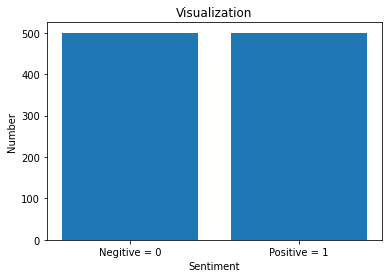

In [51]:
plt.bar(['Negitive = 0','Positive = 1'], n)
plt.xlabel('Sentiment')
plt.ylabel('Number')
plt.title('Visualization')
plt.show()

<b>Function Defined for processing the text data. This includes:
    <ol>
        <li>Removing stop words</li>
        <li>Removing commas, fullstops numbers, hyphens</li>
    </ol>
</b>

In [ ]:
def data_preprocess(textdata):
    Processed =[]

    urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern = '@[^\s]+'
    alphaPattern = r"[^\w]"
    sequenceFind = r"(.)\1\1+"
    sequenceReplace = r"\1\1"

    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(urlPattern, 'URL ', tweet)
        tweet = re.sub(userPattern, 'USER ', tweet)
        tweet = re.sub(alphaPattern, ' ', tweet)
        tweet = re.sub(sequenceFind, sequenceReplace, tweet)

    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI"+emojis[emoji])

    tweetWords = ''
    for text in tweet.split():
        if len(text)>2:
            tweetWords += (text +' ')

    Processed.append(tweetWords)

    return Processed